In [9]:
import math, ast
import pandas as pd 
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import text_functions as tf
from utilities import scikit_functions as sf

In [10]:
df_meta = pd.read_csv('meta.csv', index_col=0)
type_summary = df_meta.groupby('review_type').agg({'review_type':['count',]}).reset_index(drop=False).sort_values(by=('review_type', 'count'), ascending=False)
type_summary

review_type      
                count
5  single_focus  1093
2         multi   487
4    not_review   247
1       cluster   244
0         brief    82
3        no_pdf     2

In [11]:
df_single = pd.read_csv('single_author_meta.csv', index_col=0)
df_single_genre_summary = df_single.groupby('genre_parsed').agg({'genre_parsed':['count',]}).reset_index(drop=False).sort_values(by=('genre_parsed', 'count'), ascending=False)
df_single_genre_summary

genre_parsed      
               count
2   nonfiction   801
1      fiction   226
3       poetry    34
0        drama    18

In [13]:
# load ngrams data ... this will probably take about 30-60 seconds wall time

ngram_stores_lower = {}

base = 'extracted_features/ngrams'
    
for e in range(0,5):
    ngram_store = {}
    for i in df_single['record_id']:
        this_csv= f'{base}/{str(e)}/{str(i)}.csv'
        df = pd.read_csv(this_csv, index_col=0).dropna().reset_index(drop=True).set_index('ngram')
        mydict = df['count'].to_dict()
        try:
            mycounter = Counter({ast.literal_eval(k):v for k,v in mydict.items()})
        except:
            mycounter = Counter(mydict)
        ngram_store[i] = mycounter
    ngram_stores_lower[e] = ngram_store

In [14]:
# review text list of counters 
review_counters_all = [ngram_stores_lower[0][i] for i in df_single['record_id']]
review_counters_all_no_stops = tf.remove_from_list_of_dicts(stopwords.words('english')+['nan'], review_counters_all)

In [15]:
# metadata text list of counters
df_authors = pd.read_csv('authors_meta.csv', index_col=0)
df_titles = pd.read_csv('titles_meta.csv', index_col=0)
df_publishers = pd.read_csv('publishers_meta.csv', index_col=0)

df_authors = df_authors.rename(mapper={'reviewed_author_name':'match_string_raw'}, axis=1)
df_titles = df_titles.rename(mapper={'reviewed_book_title':'match_string_raw'}, axis=1)
df_publishers = df_publishers.rename(mapper={'reviewed_book_publisher':'match_string_raw'}, axis=1)

def make_columns(df):
    df['match_string_raw'] = df['match_string_raw'].fillna('')
    df['match_column'] = [tf.preprocess_text(str(i).lower()) for i in df['match_string_raw']]
    df['no_stops'] = [[d for d in i if d not in stopwords.words('english')] for i in df['match_column']]
    return df

df_authors = make_columns(df_authors)
df_titles = make_columns(df_titles)
df_publishers = make_columns(df_publishers)
df_authors.head(5)

,record_id,match_string_raw,match_column,no_stops
0,124900101,Lucien Carr,"[lucien, carr]","[lucien, carr]"
1,89760874,W. S. Jeans,"[w, s, jeans]","[w, jeans]"
2,89659668,Lord Byron,"[lord, byron]","[lord, byron]"
3,89659668,W. A. Lewis Bettany,"[w, a, lewis, bettany]","[w, lewis, bettany]"
4,124736362,Compton Mackenzie,"[compton, mackenzie]","[compton, mackenzie]"


## Naive BOW Matching

In [25]:
meta_counters_store = {}

for df in [df_authors, df_titles, df_publishers]:
    
    for e, row in df.iterrows():
        data = row['no_stops'].copy()
        try:
            meta_counters_store[row['record_id']].extend([i for i in data if i !='nan'])
        except KeyError:
            meta_counters_store[row['record_id']] = [i for i in data if i !='nan']

meta_counters_all = [Counter(meta_counters_store[i]) for i in df_single['record_id']]

In [26]:
review_meta_combined = review_counters_all_no_stops + meta_counters_all

In [27]:
v = DictVectorizer(sparse=False)
X = v.fit_transform(review_meta_combined)
X_reviews_only = v.transform(review_counters_all_no_stops)
X_meta_only = v.transform(meta_counters_all)

# to here

In [28]:
%%time
reviews_meta_records = sf.pairwise_cosine(X_reviews_only, X_meta_only)

CPU times: user 3min 51s, sys: 21.1 s, total: 4min 12s
Wall time: 4min 13s


In [29]:
%%time
reviews_meta_scores = sf.pairwise_performance(reviews_meta_records)

CPU times: user 18.3 s, sys: 5.31 s, total: 23.6 s
Wall time: 23.8 s


In [30]:
reviews_meta_scores[0], len(reviews_meta_scores) 

([1, 0.8619091751621872], 791)

## Pretrained NER

In [31]:
df_ents_joined = pd.read_csv('extracted_features/spacy_entities_all.csv', index_col=0)
df_ents_joined.head(5)

,record_id,text,start_char,end_char,label
0,124900101,the States of the Union,169,192,GPE
1,124900101,Missouri,254,262,GPE
2,124900101,Missouri,347,355,GPE
3,124900101,Union,448,453,ORG
4,124900101,the Civil War,478,491,EVENT


In [32]:
spacy_ner_counters_store = {}
entities = ['PERSON', 'GPE', 'NORP', 'ORG', 'FAC', 'EVENT', 'LOC', 'PRODUCT', 'WORK_OF_ART', 'LAW']        
df_ents_selected = df_ents_joined.loc[df_ents_joined['label'].isin(entities)]
df_ents_selected['match_column'] = [tf.preprocess_text(str(i).lower()) for i in df_ents_selected['text']]
df_ents_selected['no_stops'] = [[d for d in i if d not in stopwords.words('english')] for i in df_ents_selected['match_column']]
df_ents_selected.head(5)


/Users/matthewlavin/miniforge3/envs/.miniconda_env/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,record_id,text,start_char,end_char,label,match_column,no_stops
0,124900101,the States of the Union,169,192,GPE,"[the, states, of, the, union]","[states, union]"
1,124900101,Missouri,254,262,GPE,[missouri],[missouri]
2,124900101,Missouri,347,355,GPE,[missouri],[missouri]
3,124900101,Union,448,453,ORG,[union],[union]
4,124900101,the Civil War,478,491,EVENT,"[the, civil, war]","[civil, war]"


In [33]:
for e, row in df_ents_selected.iterrows():
    data = row['no_stops'].copy()
    try:
        spacy_ner_counters_store[row['record_id']].extend(data)
    except KeyError:
        spacy_ner_counters_store[row['record_id']] = data
            
spacy_ner_counters_all = [Counter(spacy_ner_counters_store[i]) for i in df_single['record_id']]

In [34]:
spacy_meta_combined = spacy_ner_counters_all + meta_counters_all

v = DictVectorizer(sparse=False)
X = v.fit_transform(spacy_meta_combined)
X_spacy_ner_only = v.transform(spacy_ner_counters_all)
X_meta_only = v.transform(meta_counters_all)

In [35]:
spacy_meta_records = sf.pairwise_cosine(X_spacy_ner_only, X_meta_only)

In [36]:
spacy_meta_scores = sf.pairwise_performance(spacy_meta_records)

In [37]:
spacy_meta_scores[0], len(spacy_meta_scores)

([1, 0.8470806302131604], 768)

## Rule-Based Matching

In [38]:
# select features based on all matching title ngrams, publisher ngrams, author surnames and associated names 
x1 = list(df_publishers['no_stops'])
pub_tokens = list(set([j for i in x1 for j in i]))

x2 = list(df_titles['no_stops'])
title_tokens = list(set([j for i in x2 for j in i]))

In [39]:
# load extracted author data
df_ac = pd.read_csv('extracted_features/author_candidates.csv', index_col=0)
df_an = pd.read_csv('extracted_features/associated_names.csv', index_col=0)

# remove nan, lowercase all, reduce to unique 
x3 = [eval(i) for i in df_ac.loc[df_ac['entity'] != 'nan']['entity']] 
x4 = [eval(i) for i in df_an.loc[df_an['entity'] != 'nan']['entity']]  

candidate_tokens = list(set([j.lower() for i in x3 for j in i]))
associated_tokens = list(set([j.lower() for i in x4 for j in i]))

In [40]:
extracted_feature_tokens = [i for i in list(set(candidate_tokens + associated_tokens + pub_tokens + title_tokens)) if i != 'nan']
len(pub_tokens), len(title_tokens), len(candidate_tokens), len(associated_tokens), len(extracted_feature_tokens)

(363, 1959, 2009, 2468, 4272)

In [41]:
review_counters_extracted_features = tf.cull_list_of_dicts(extracted_feature_tokens, review_counters_all)

In [42]:
extracted_meta_combined = review_counters_extracted_features + meta_counters_all

v = DictVectorizer(sparse=False)
X = v.fit_transform(extracted_meta_combined)
X_extracted_only = v.transform(review_counters_extracted_features)
X_meta_only = v.transform(meta_counters_all)

In [43]:
extracted_meta_records = sf.pairwise_cosine(X_extracted_only, X_meta_only)
extracted_meta_scores = sf.pairwise_performance(extracted_meta_records)

In [44]:
df_scores_bow = pd.DataFrame.from_records(reviews_meta_scores, columns = ['window', 'recall']).set_index('window')
df_scores_rules = pd.DataFrame.from_records(extracted_meta_scores, columns = ['window', 'recall']).set_index('window')
df_scores_ner = pd.DataFrame.from_records(spacy_meta_scores, columns = ['window', 'recall_ner']).set_index('window')

df_scores_all = df_scores_bow.join(df_scores_rules, lsuffix='_bow', rsuffix='_rules').join(df_scores_ner).reset_index()
df_scores_all = df_scores_all.loc[df_scores_all['window'] % 5 == 0]
df_scores_all = df_scores_all.head(10)


dfm = df_scores_all.rename(mapper={'recall_bow':'Naive BOW', 'recall_ner':'Pretrained NER', 'recall_rules':'Rule-based', }, axis=1).melt('window', var_name='column', value_name='score')
dfm

,window,column,score
0,5,Naive BOW,0.954588
1,10,Naive BOW,0.972196
2,15,Naive BOW,0.979611
3,20,Naive BOW,0.983318
4,25,Naive BOW,0.986098
5,30,Naive BOW,0.987025
6,35,Naive BOW,0.988879
7,40,Naive BOW,0.991659
8,45,Naive BOW,0.991659
9,50,Naive BOW,0.992586


[Text(0.5, 1.0, 'Predicted Label is Correct or Close'),
 Text(0, 0.5, 'Percent of Reviews Correct or Close'),
 Text(0.5, 0, 'Proximity Threshold')]

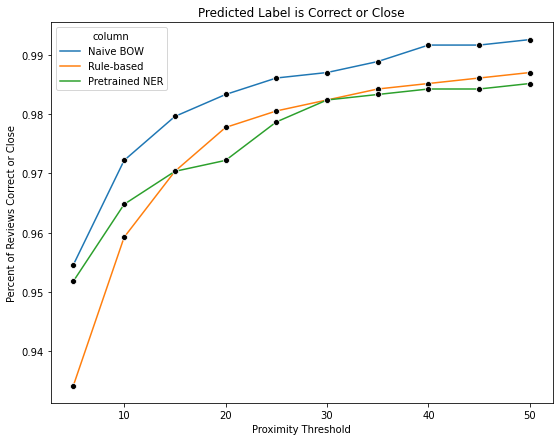

In [45]:
fig = plt.subplots(figsize=(9, 7))
sns.lineplot(x='window', y='score', hue='column', data=dfm, marker='o', markerfacecolor='black').set(title='Predicted Label is Correct or Close', ylabel='Percent of Reviews Correct or Close', xlabel='Proximity Threshold')


In [46]:
extracted_meta_scores[789]

[790, 0.9990732159406858]

In [47]:
spacy_meta_scores[-1]

[768, 1.0]

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score

def prf(records):
    df = sf.pairwise_df(records)
    return precision_score(df['source'], df['target'], average='weighted', zero_division=0.0), recall_score(df['source'], df['target'], average='weighted'), f1_score(df['source'], df['target'], average='weighted')

prf(reviews_meta_records), prf(extracted_meta_records), prf(spacy_meta_records)

((0.8168460825550723, 0.8619091751621872, 0.8301301108530023),
 (0.786430791037453, 0.8396663577386468, 0.8021198346499551),
 (0.7925084955205438, 0.8470806302131604, 0.8091941731422733))

## False Positives Analysis

In [50]:
def analyze_fp(df):
    df_fp = df.loc[df['source'] != df['target']]
    fp_counts = df_fp.groupby('target').count()[['score']].sort_values(by='score', ascending=False)
    return fp_counts

def tp_vs_fp_scores(df, index):
    return df.loc[df['target'] == index].sort_values(by='score', ascending=False)

In [51]:
naive_df = sf.pairwise_df(reviews_meta_records)
naive_fp = analyze_fp(naive_df)

spacy_df = sf.pairwise_df(spacy_meta_records)
spacy_fp = analyze_fp(spacy_df)

extracted_df = sf.pairwise_df(extracted_meta_records)
extracted_fp = analyze_fp(extracted_df)

In [52]:
fps_joined = naive_fp.join(spacy_fp, how='outer', lsuffix='_naive', rsuffix='_spacy').join(extracted_fp, how='outer').fillna(0).rename(mapper={'score':'extracted_score'}, axis=1)
fps_joined['sum'] = fps_joined.sum(axis=1)
fps_joined['mean_naive_extracted'] = (fps_joined['score_naive'] + fps_joined['extracted_score'])/2

In [53]:
fps_joined.sort_values(by='score_spacy', ascending=False).head(8)

,score_naive,score_spacy,extracted_score,sum,mean_naive_extracted
target,,,,,
707,1.0,11.0,1.0,13.0,1.0
276,1.0,4.0,3.0,8.0,2.0
770,0.0,4.0,0.0,4.0,0.0
394,2.0,3.0,2.0,7.0,2.0
181,1.0,3.0,1.0,5.0,1.0
892,3.0,3.0,5.0,11.0,4.0
1047,0.0,2.0,0.0,2.0,0.0
346,1.0,2.0,1.0,4.0,1.0


In [54]:
fps_joined.sort_values(by='mean_naive_extracted', ascending=False).head(15).reset_index()

,target,score_naive,score_spacy,extracted_score,sum,mean_naive_extracted
0,63,12.0,0.0,16.0,28.0,14.0
1,607,5.0,0.0,5.0,10.0,5.0
2,7,9.0,0.0,0.0,9.0,4.5
3,1033,4.0,0.0,5.0,9.0,4.5
4,720,3.0,0.0,5.0,8.0,4.0
5,892,3.0,3.0,5.0,11.0,4.0
6,769,3.0,0.0,3.0,6.0,3.0
7,824,3.0,0.0,3.0,6.0,3.0
8,926,2.0,0.0,3.0,5.0,2.5
9,482,2.0,0.0,3.0,5.0,2.5


In [55]:
worst_spacy = fps_joined.sort_values(by='score_spacy', ascending=False).head(3).index.to_list()
worst_overall = fps_joined.sort_values(by='sum', ascending=False).head(15).index.to_list()
worst_naive_extracted = fps_joined.sort_values(by='mean_naive_extracted', ascending=False).head(15).index.to_list()

In [56]:
print(fps_joined[['score_naive','score_spacy','extracted_score']].corr().to_markdown())

|                 |   score_naive |   score_spacy |   extracted_score |
|:----------------|--------------:|--------------:|------------------:|
| score_naive     |      1        |     -0.173245 |          0.824175 |
| score_spacy     |     -0.173245 |      1        |         -0.150329 |
| extracted_score |      0.824175 |     -0.150329 |          1        |


In [57]:
def index_to_meta(fp_index):
    ri = df_single.reset_index().iloc[fp_index]['record_id']
    a = ' '.join(df_authors.loc[df_authors['record_id'] == ri]['match_string_raw'].to_list())
    t = ' '.join(df_titles.loc[df_titles['record_id'] == ri]['match_string_raw'].to_list())
    p = ' '.join(df_publishers.loc[df_publishers['record_id'] == ri]['match_string_raw'].to_list())
    return [a,t,p]


In [58]:
for i in worst_spacy:
    print(index_to_meta(i))

['Cahan', 'A Tale of the New York Ghetto', 'D. Appleton & Co']
['John D. Long', 'The New American Navy', 'The Outlook Co.']
['James Smethan', 'Letters of James Smetham', 'Macmillan & Co.']


In [59]:
for i in worst_spacy:
    print(meta_counters_all[i].keys())

dict_keys(['cahan', 'tale', 'new', 'york', 'ghetto', 'appleton', 'co'])
dict_keys(['john', 'long', 'new', 'american', 'navy', 'outlook', 'co'])
dict_keys(['james', 'smethan', 'letters', 'smetham', 'macmillan', 'co'])


In [60]:
for i in worst_naive_extracted :
    print(index_to_meta(i))

['Schuyler Van Rensselaer', 'One Man Who Was Content', 'The Century Company']
['Adam', 'My Literary Life', 'Appleton']
['Mr. Benson', 'Mrs. Ames', '']
['Cuthbert Wright', 'One Way of Love', 'Elkin Mathews']
['Iles', 'Inventors at Work', 'Doubleday, Page & Co.']
['Henri de Régnier', "L'Illusion Heroique de Tito Bassi", 'Mercure de France']
['Lafarge', 'One Hundred Masterpieces of Painting', 'Doubleday, Page & Co.']
['Graham', 'Socialism New and Old', 'D. Appleton & Co']
['Marion Harland', 'The Story of a Long Life', 'Harper & Brothers']
['Canon Luckock', 'Studies in the history of the book of common prayer', '']
['Georges Perrot', 'History of Art in Ancient Greece: Mycenian Art', 'A.C. Armstrong & Son']
['P. Chalmers Mitchell', 'Thomas Henry Huxley: A Sketch of His Life and Work', "G. P. Putnam's Sons"]
['John M. Armour', 'Atonement and Law: Or, redemption in harmony with law as revealed in nature', 'The Christian Statesman Publishing Co.']
['Frank Dilnot', 'Lloyd George: The Man and Hi

In [61]:
for i in worst_naive_extracted:
    print(meta_counters_all[i].keys())

dict_keys(['schuyler', 'van', 'rensselaer', 'one', 'man', 'content', 'century', 'company'])
dict_keys(['adam', 'literary', 'life', 'appleton'])
dict_keys(['mr', 'benson', 'mrs', 'ames'])
dict_keys(['cuthbert', 'wright', 'one', 'way', 'love', 'elkin', 'mathews'])
dict_keys(['iles', 'inventors', 'work', 'doubleday', 'page', 'co'])
dict_keys(['henri', 'de', 'régnier', 'l', 'illusion', 'heroique', 'tito', 'bassi', 'mercure', 'france'])
dict_keys(['lafarge', 'one', 'hundred', 'masterpieces', 'painting', 'doubleday', 'page', 'co'])
dict_keys(['graham', 'socialism', 'new', 'old', 'appleton', 'co'])
dict_keys(['marion', 'harland', 'story', 'long', 'life', 'harper', 'brothers'])
dict_keys(['canon', 'luckock', 'studies', 'history', 'book', 'common', 'prayer'])
dict_keys(['georges', 'perrot', 'history', 'art', 'ancient', 'greece', 'mycenian', 'ac', 'armstrong', 'son'])
dict_keys(['p', 'chalmers', 'mitchell', 'thomas', 'henry', 'huxley', 'sketch', 'life', 'work', 'g', 'putnam', 'sons'])
dict_keys(

In [62]:
for i in worst_spacy:
    print(list(spacy_ner_counters_all[i].keys()))

['tim', 'explorer', 'cahan', 'new', 'york', 'ghetto', 'jews', 'suffolk', 'street', 'philadelphians', 'russia', 'french', 'europe', 'poland', 'galicia', 'hungary', 'roumania', 'jew', 'russified', 'moscow', 'st', 'petersburg', 'kieff', 'saratoff', 'jewish', 'russian', 'houston', 'delancey', 'rivington', 'broome', 'lounger']
['long', 'n', 'outlook', 'co', 'mir', 'american', 'navy', 'spanish', 'war', 'schley', 'sampson']
['raph', 'ael', 'penny', 'magazine', 'lincoln', 'cathedral', 'shropshire', 'london', 'royal', 'academy', 'liverpool', 'normal', 'college', 'westminster', 'ruskin', 'james', 'smetham', 'introductory', 'memoir', 'sarah', 'william', 'davies', 'macmillan', 'co', 'watts', 'dream', 'pilate', 'wife', 'women', 'crucifixion', 'rossetti', 'methodist', 'mahomet', 'tennyson', 'hawthorne', 'hunstanton', 'sea']


In [63]:
tp_vs_fp_scores(naive_df, 63)

,source,target,score
63,63,63,0.358364
34,34,63,0.187952
604,604,63,0.176973
348,348,63,0.167219
120,120,63,0.164088
701,701,63,0.163188
1044,1044,63,0.159919
15,15,63,0.154303
392,392,63,0.149297
182,182,63,0.146599


In [64]:
tp_vs_fp_scores(naive_df, 707)

,source,target,score
707,707,707,0.251295
760,760,707,0.075499


In [65]:
def describe_tp_fp(df, strategy):
    # naive TPs
    tp = pd.DataFrame(df.loc[df['source'] == df['target']]['score'].describe())
    fp = pd.DataFrame(df.loc[df['source'] != df['target']]['score'].describe())
    joined = tp.join(fp, lsuffix='_tp', rsuffix='_fp')
    return joined.rename(mapper={'score_tp':f'{strategy}_tp', 'score_fp':f'{strategy}_fp', }, axis=1)


In [66]:
naive_d = describe_tp_fp(naive_df, 'naive')
spacy_d = describe_tp_fp(spacy_df, 'ner')
extracted_d = describe_tp_fp(extracted_df, 'rule_based')

joined_d = naive_d.join(spacy_d).join(extracted_d)
print(joined_d[joined_d.index.isin(['mean', '25%','50%','75%','min', 'max'])].to_markdown())

|      |   naive_tp |   naive_fp |    ner_tp |    ner_fp |   rule_based_tp |   rule_based_fp |
|:-----|-----------:|-----------:|----------:|----------:|----------------:|----------------:|
| mean |  0.279798  |  0.195457  | 0.48145   | 0.324069  |        0.37251  |       0.25451   |
| min  |  0.0899659 |  0.0589883 | 0.0836003 | 0.0766965 |        0.142857 |       0.0741332 |
| 25%  |  0.216619  |  0.146599  | 0.374897  | 0.233882  |        0.296421 |       0.199667  |
| 50%  |  0.273474  |  0.179167  | 0.472631  | 0.306186  |        0.368572 |       0.234146  |
| 75%  |  0.334566  |  0.226339  | 0.581786  | 0.401663  |        0.439044 |       0.287023  |
| max  |  0.601052  |  0.515969  | 0.981266  | 0.746203  |        0.708333 |       0.655562  |


In [67]:

def logit_on_cos_sim(df):
    X = df.loc[df['source'] != df['target']]['score'].to_list() +  df.loc[df['source'] == df['target']]['score'].to_list()
    X_array = np.array(X).reshape(-1, 1)
    y = [ 1 for i in df.loc[df['source'] != df['target']]['score'].to_list()] + [0 for i in df.loc[df['source'] == df['target']]['score'].to_list()]
    clf = LogisticRegression(class_weight={0: 0.2, 1:0.8}).fit(X_array, y)
    predicted = clf.predict(X_array)
    probs = clf.predict_proba(X_array)
    #return clf.score(X_array, y)
    df_logit = pd.DataFrame()
    df_logit['score'] = X
    df_logit['predicted'] = predicted
    df_logit['actual'] = y
    df_logit['prob_correct'] = [i[0] for i in probs]
    df_logit['prob_incorrect'] = [i[1] for i in probs]
    df_logit['correctly_classified'] = df_logit['predicted'] == df_logit['actual']
    df_logit_sorted = df_logit.sort_values(by='score')
    return df_logit_sorted

def model_acc(df):
    return df.loc[df['predicted'] == df['actual']].shape[0]/df.shape[0]

In [68]:
df_logit_naive = logit_on_cos_sim(naive_df)
model_acc(df_logit_naive)

0.8628359592215014

In [69]:
df_logit_spacy = logit_on_cos_sim(spacy_df)
model_acc(df_logit_spacy)

0.798887859128823

In [70]:
df_logit_extracted = logit_on_cos_sim(extracted_df)
model_acc(df_logit_extracted)

0.8359592215013901

In [71]:
def get_quantile_accuracy(df, q=5):
    r = math.ceil(df.shape[0]/q)
    df_low = df.head(r)
    df_high = df.tail(r*(q-1))
    output = []
    for i in [df_low, df_high]:
        this_df = i.groupby(['predicted', 'actual']).count()[['score']].rename(mapper={'score':'count'}, axis=1)
        output.append(this_df)
        this_df['min_cos_sim'] = i['score'].min()
        this_df['max_cos_sim'] = i['score'].max()
    return output[0].join(output[1], how='outer', lsuffix='_low', rsuffix='_high')

get_quantile_accuracy(df_logit_naive)

count_low  min_cos_sim_low  max_cos_sim_low  count_high  \
predicted actual                                                            
0         0             112         0.058988          0.19087       802.0   
          1              69         0.058988          0.19087        62.0   
1         0              17         0.058988          0.19087         NaN   
          1              18         0.058988          0.19087         NaN   

                  min_cos_sim_high  max_cos_sim_high  
predicted actual                                      
0         0                0.19087          0.601052  
          1                0.19087          0.601052  
1         0                    NaN               NaN  
          1                    NaN               NaN

In [72]:
quantiles_naive = get_quantile_accuracy(df_logit_naive)
quantiles_extracted = get_quantile_accuracy(df_logit_extracted)
quantiles_spacy = get_quantile_accuracy(df_logit_spacy)

m = {}
for i in quantiles_spacy.columns:
    m[i] = i + '_spacy'    
    
quantiles_spacy = quantiles_spacy.rename(mapper=m, axis=1)

In [73]:
quantiles_joined = quantiles_naive.join(quantiles_extracted, lsuffix='_naive', rsuffix='_extracted').join(quantiles_spacy).fillna(0).reset_index()

for i in ['naive', 'extracted', 'spacy']:
    quantiles_joined['sum_'+i] = quantiles_joined[f'count_low_{i}'] + quantiles_joined[f'count_high_{i}']

quantiles_joined

quantiles_separated = []
for x in ['naive', 'extracted', 'spacy']:
    quantiles_separated.append(quantiles_joined[['predicted', 'actual'] + [i for i in quantiles_joined.columns if x in i]])
quantiles_separated[2][[i for i in quantiles_separated[2].columns if 'cos_sim' in i]]


,min_cos_sim_low_spacy,max_cos_sim_low_spacy,min_cos_sim_high_spacy,max_cos_sim_high_spacy
0,0.000000,0.000000,0.315584,0.981266
1,0.000000,0.000000,0.315584,0.981266
2,0.076696,0.315584,0.315584,0.981266
3,0.076696,0.315584,0.315584,0.981266


In [74]:
for x in quantiles_separated:
    #x_selected = x[[i for i in x.columns if 'count' in i]]
    correct = x.loc[x['predicted'] == x['actual']].set_index('actual')
    accuracies = []
    for y in ['count_low', 'count_high']:
        c = [i for i in x.columns if y in i]
        acc = correct.sum()[c[0]] / x.sum()[c[0]]
        print(y, acc)
        accuracies.append(acc)

count_low 0.6018518518518519
count_high 0.9282407407407407
count_low 0.5138888888888888
count_high 0.9155092592592593
count_low 0.4305555555555556
count_high 0.8912037037037037


In [75]:
math.ceil(1079/4)

270

In [76]:
df_logit_naive.tail(500).groupby(['actual']).count()

,score,predicted,prob_correct,prob_incorrect,correctly_classified
actual,,,,,
0,477,477,477,477,477
1,23,23,23,23,23


In [77]:
def p_r_plot(df, strategy):
    mpl.rcParams['lines.markersize'] = 4 
    fig = plt.subplots(figsize=(9, 7))
    precision, recall, thresholds = precision_recall_curve(df['actual'],df['prob_correct'], pos_label=0)
    df_pr_curve = pd.DataFrame()
    df_pr_curve['precision'] = precision
    df_pr_curve['recall'] = recall
    df_pr_curve['thresholds'] = np.insert(thresholds, 0, 0)
    sns.lineplot(x='recall', y='precision', data=df_pr_curve, marker='o', markerfacecolor='black').set(title=f'Precision-Recall Curve ({strategy} Model)', ylabel='Precision', xlabel='Recall')
    return df_pr_curve


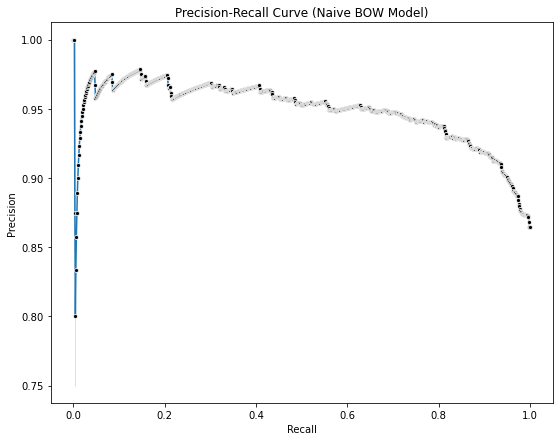

In [78]:
naive_curve = p_r_plot(df_logit_naive, "Naive BOW")

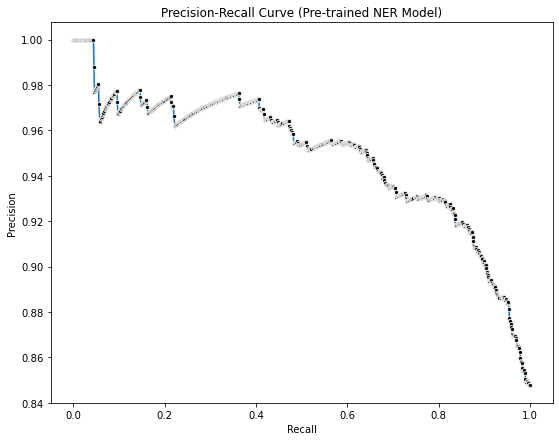

In [79]:
spacy_curve = p_r_plot(df_logit_spacy, "Pre-trained NER")

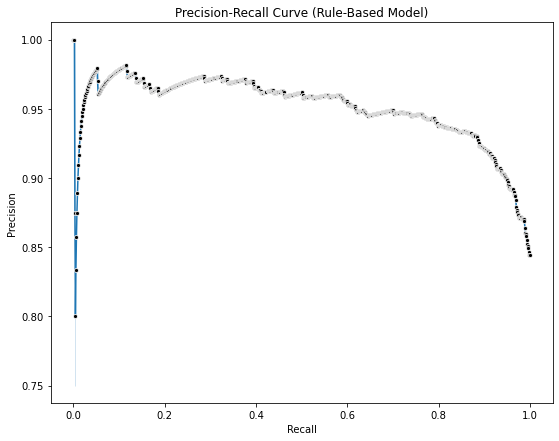

In [80]:
extracted_curve = p_r_plot(df_logit_extracted, "Rule-Based")